In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#importing project specific functions to match changes in EDA notebook
from model_prep import get_feature_name, model_transformer_train

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:63618" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:63641, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:63635, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:63638, threads: 2>})

In [5]:
model_data = pd.read_pickle('Data/model_data.pkl')

In [6]:
model_data.columns

Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'urban_rural', 'year', 'month',
       'years_old', 'popbins'],
      dtype='object')

# Prepping Data

Now that we have read in the data from the EDA and cleaning step, we need to preprocess it for the model. We will scale the data in the numeric columns gps_height and population so that there larger values don't force them to be unrealistically important features. We will also One Hot Encode our categorical features to allow the model to receive them. Though Random Froest doesn't need this step, our PCA and XGBoost algorithms do.

In [7]:
model_data.drop(columns=['id'], inplace=True)

In [8]:
num_cols = ['gps_height', 'population']
cat_cols = ['basin', 'region_code', 'district_code', 'extraction_type', 'payment_type', 'water_quality', 'quantity', 
            'source', 'management', 'management_group', 'waterpoint_type',  'funder', 'installer', 'subvillage', 
            'ward', 'scheme_management', 'scheme_name', 'popbins', 'lga', 'urban_rural']

In [9]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True, sparse_threshold=0)

In [10]:
def prep_train(unprepped_values, class_col):
    #splits the data into a train and test set ensuring that transformations are based only on the train set assuming we 
    #haven't seen the test set before
    train_X, test_X, train_y, test_y = train_test_split(unprepped_values.drop(columns=[class_col]), 
                                                        unprepped_values[class_col], test_size=0.25, random_state=42)
    train_Xct = CT.fit_transform(train_X)
    
    test_Xct = CT.transform(test_X)

    cols = get_feature_name(CT)
    train_Xf = pd.DataFrame(train_Xct, columns=cols)
    cols = get_feature_name(CT)
    test_Xf = pd.DataFrame(test_Xct, columns=cols)
    
    return train_Xf, train_y, test_Xf, test_y   

In [11]:
def prep_submit(unprepped_values):
    #prepares the submission test set as we do our learning set, without refitting to the unseen data
    submit_X= unprepped_values
        
    submit_Xt = model_transformer_train(submit_X)
    submit_Xct = CT.transform(submit_Xt)

    cols = get_feature_name(CT)
    submit_Xf = pd.DataFrame(submit_Xct.todense(), columns=cols)
    
    return submit_Xf

In [12]:
train_Xf, train_y, test_Xf, test_y = prep_train(model_data, 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.3s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


# PCA 

We will start with dimensionality reduction via principal component analysis. We hope this will split out some of the noise in the dataset by focusing on the features that explain the most variance. This will also help with compute time. 

In [13]:
pca = PCA()
pca.fit(train_Xf)
pca.explained_variance_ratio_[:10]

array([9.99282656e-01, 5.19432104e-04, 7.03316034e-05, 3.10705038e-05,
       2.44460590e-05, 6.99218722e-06, 5.28537142e-06, 4.46587157e-06,
       3.19128997e-06, 2.83729941e-06])

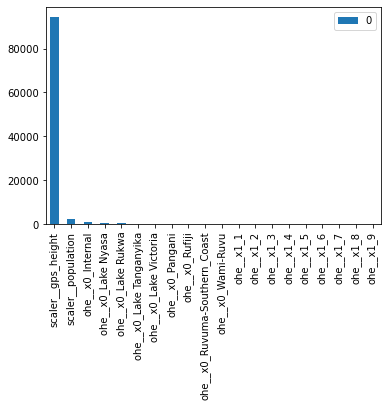

In [14]:
ex_var = pd.DataFrame(pca.singular_values_.reshape(1,-1), columns=train_Xf.columns).T.sort_values(by=0, ascending=False)
ex_var.head(20).plot(kind='bar')
plt.show()

In [15]:
pca = PCA()
pca.fit(train_Xf.drop(columns=['scaler__gps_height']))
pca.explained_variance_ratio_[:10]

array([9.99287645e-01, 5.19429620e-04, 6.95083777e-05, 3.10501273e-05,
       2.36028979e-05, 6.03630444e-06, 5.22423454e-06, 4.46567681e-06,
       2.83807544e-06, 2.49083111e-06])

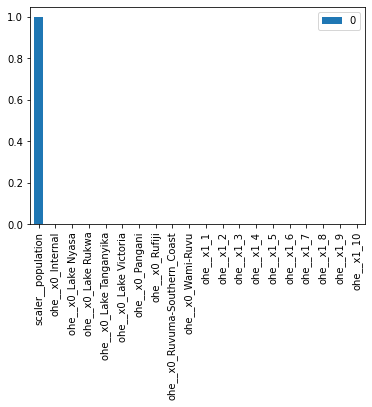

In [16]:
ex_var = pd.DataFrame(pca.explained_variance_ratio_.reshape(1,-1), columns=train_Xf.drop(columns=['scaler__gps_height']).columns).T.sort_values(by=0, ascending=False)
ex_var.head(20).plot(kind='bar')
plt.show()

# Random Forest Classifier

We will start with the Random Forest Classifier which is pretty common becuase of it's predicitive power. We will run using all features first and then we can compare the different amount of features to see what performs best.

In [17]:
rf = RandomForestClassifier(n_estimators = 250, criterion='entropy', #max_samples=.75, #max_depth=16,  
                            class_weight='balanced_subsample', verbose=True)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xf, train_y)
rf.score(test_Xf, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   29.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.2s finished


0.8065993265993266

In [18]:
pd.DataFrame(rf.feature_importances_.reshape(1,-1), columns=train_Xf.columns).T.sort_values(by=0, ascending=False).head(30)

,0
longitude,0.098111
latitude,0.093608
scaler__gps_height,0.087485
ohe__x6_dry,0.042997
years_old,0.038687
scaler__population,0.034541
month,0.020383
ohe__x6_enough,0.018411
amount_tsh,0.016889
ohe__x3_other,0.014972


In [19]:
with joblib.parallel_backend('dask'):
    print(cross_val_score(rf, train_Xf, train_y, cv=5))

[0.80819304 0.80359147 0.8016835  0.8040404  0.80392817]


In [18]:
rf = RandomForestClassifier(n_estimators = 150, criterion='entropy', max_depth=16)
                            #class_weight={'functional':1,'non functional':1.25,'funtional needs repair':10})
pca = PCA(n_components=20)
train_Xfpca = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xfpca, train_y)
test_Xfpca = pca.transform(test_Xf)
rf.score(test_Xfpca, test_y)

0.7847811447811448

In [19]:
scoresrf = {'components':[], 'accuracy':[]}
rf = RandomForestClassifier(n_estimators = 150, criterion='entropy', max_depth=16, verbose=True)
                            #class_weight={'functional':1,'non functional':1.25,'funtional needs repair':10})
for i in [3, 5, 10, 20, 50, 75, 100, 200]:
    pca = PCA(n_components=i)
    train_Xfpca = pca.fit_transform(train_Xf)
    with joblib.parallel_backend('dask'):
        rf.fit(train_Xfpca, train_y)
    test_Xfpca = pca.transform(test_Xf)
    scoresrf['components'].append(i)
    scoresrf['accuracy'].append(rf.score(test_Xfpca, test_y))

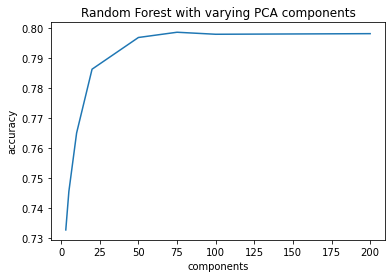

In [20]:
sns.lineplot(data= pd.DataFrame(scoresrf), x='components', y='accuracy')
plt.title('Random Forest with varying PCA components')
plt.show()

<Figure size 2880x576 with 0 Axes>

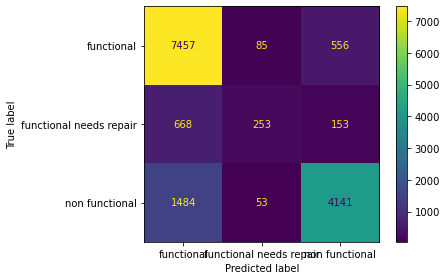

In [21]:
pca = PCA(n_components=200)
pca.fit(train_Xf)
test_Xfrf = pca.transform(test_Xf)
rf = RandomForestClassifier(n_estimators = 250, criterion='entropy', #max_samples=.75, #max_depth=16,  
                            class_weight='balanced_subsample', verbose=True)
y_pred = rf.predict(test_Xfrf)
cm=confusion_matrix(test_y, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.show()
rf.score(test_Xfpca, test_y)

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.1s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.804040404040404


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.0s finished


<Figure size 2880x576 with 0 Axes>

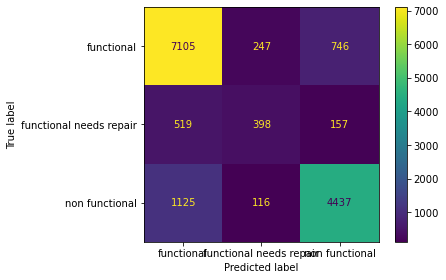

In [43]:
train_Xf, train_y, test_Xf, test_y = prep_train(model_data, 'class')

rf = RandomForestClassifier(n_estimators = 250, criterion='entropy', #max_samples=.75, #max_depth=16,  
                            class_weight='balanced_subsample', verbose=True)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xf, train_y)
print(rf.score(test_Xf, test_y))
y_pred = rf.predict(test_Xf)
cm=confusion_matrix(test_y, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.show()

In [46]:
with joblib.parallel_backend('dask'):
    print(cross_val_score(rf, train_Xf, train_y, cv=5))

[0.81122334 0.80729517 0.8037037  0.8047138  0.80246914]


# XGBoost

In [22]:
scoresxgb = {'components':[], 'accuracy':[]}
xgb = XGBClassifier()
for i in [3, 5, 10, 20, 50, 75, 100]:
    pca = PCA(n_components=i)
    train_Xfpca = pca.fit_transform(train_Xf)
    with joblib.parallel_backend('dask'):
        xgb.fit(train_Xfpca, train_y)
    test_Xfpca = pca.transform(test_Xf)
    scoresxgb['components'].append(i)
    scoresxgb['accuracy'].append(xgb.score(test_Xfpca, test_y))

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:35] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:44] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:44:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:44:35] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:45:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:46:45] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


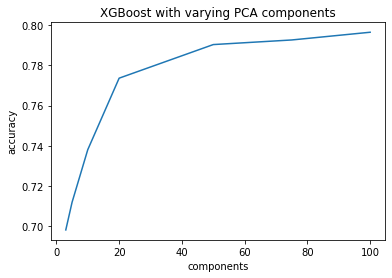

In [23]:
sns.lineplot(data= pd.DataFrame(scoresxgb), x='components', y='accuracy')
plt.title('XGBoost with varying PCA components')
plt.show()

Both RandomFoest and XGBoost have a plateauing around 100 components. This allows us to cleanout nearly half the variables and should reduce noise as well as increase compute time.

<Figure size 2880x576 with 0 Axes>

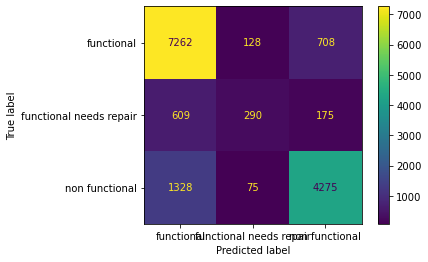

In [24]:
test_Xfxgb = pca.transform(test_Xf)
y_pred = xgb.predict(test_Xfxgb)
cm=confusion_matrix(test_y, y_pred, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
plt.figure(figsize=(40,8))
disp.plot()

# K Nearest Neighbors

In [27]:
knn = KNeighborsClassifier(n_neighbors=10)
pca = PCA(n_components=100)
train_Xfknn = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    knn.fit(train_Xfknn, train_y)
test_Xfknn = pca.transform(test_Xf)
knn.score(test_Xfknn, test_y)

0.7583164983164983

In [30]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
pca = PCA(n_components=100)
train_Xfknn = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    knn.fit(train_Xfknn, train_y)
test_Xfknn = pca.transform(test_Xf)
knn.score(test_Xfknn, test_y)

0.7674074074074074

<Figure size 2880x576 with 0 Axes>

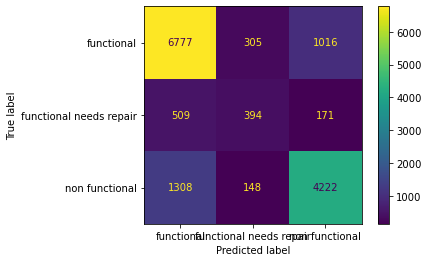

In [29]:
y_pred = knn.predict(test_Xfknn)
cm=confusion_matrix(test_y, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
plt.figure(figsize=(40,8))
disp.plot()